In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class KohonenNet:
    def __init__(self, m, n, input_dim, sigma=1.0, sigma_decay=0.1, learning_rate=0.1, lambda_decay=100):
        self.bmu_to_cluster_map = None
        self.m = m
        self.n = n
        self.input_dim = input_dim
        self.sigma = sigma
        self.sigma_decay = sigma_decay
        self.learning_rate = learning_rate
        self.lambda_decay = lambda_decay
        self.weights = np.random.rand(m, n, input_dim)  # Inicjalizacja wag
        self.predictions = []

    def train(self, data, labels, epochs):
        self.bmu_to_cluster_map = np.zeros((self.m, self.n), dtype=int)
        cluster_count = {}
        for epoch in range(epochs):
            for sample, label in zip(data, labels):
                bmu_idx = self.find_bmu(sample)
                if bmu_idx not in cluster_count:
                    cluster_count[bmu_idx] = {}
                if label not in cluster_count[bmu_idx]:
                    cluster_count[bmu_idx][label] = 0
                cluster_count[bmu_idx][label] += 1
                self.update_weights(sample, bmu_idx, epoch)
    
        # Determine the predominant cluster for each BMU
        for bmu_idx, counts in cluster_count.items():
            self.bmu_to_cluster_map[bmu_idx] = max(counts, key=counts.get)


    def find_bmu(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    def update_weights(self, sample, bmu_idx, t):
        bmu_x, bmu_y = bmu_idx
        alpha = self.learning_rate * np.exp(-t / self.lambda_decay)
        sigma_t = self.sigma * np.exp(-t / self.lambda_decay)

        for i in range(self.m):
            for j in range(self.n):
                d = np.linalg.norm(np.array([i, j]) - np.array([bmu_x, bmu_y]))
                influence = self.gaussian(d, sigma_t)
                self.weights[i, j] += alpha * influence * (sample - self.weights[i, j])

    def map_clusters(self, data, labels):
        """
        Assigns samples to the nearest neuron and analyzes coverage with expected clusters.

        :param data: Input data.
        :param labels: Cluster labels for the input data.
        :return: None
        """ 
        cluster_map = {}
        for sample, label in zip(data, labels):
            bmu_idx = self.find_bmu(sample)
            if bmu_idx not in cluster_map:
                cluster_map[bmu_idx] = []
            cluster_map[bmu_idx].append(label)

        # Prepare a matrix to hold the predominant cluster and its percentage for each BMU
        cluster_matrix = np.zeros((self.m, self.n))
        percentage_matrix = np.zeros((self.m, self.n))

        # Analysis of cluster coverage
        for (x, y), cluster_labels in cluster_map.items():
            most_common = max(set(cluster_labels), key=cluster_labels.count)
            percentage = cluster_labels.count(most_common) / len(cluster_labels) * 100
            cluster_matrix[x, y] = most_common
            percentage_matrix[x, y] = percentage
            print(f"BMU ({x}, {y}) is mostly representing cluster {most_common} ({percentage:.2f}% of samples)")

        # Visualizing the results
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        cmap = plt.get_cmap('viridis')

        # Cluster ID map
        im1 = axs[0].imshow(cluster_matrix, cmap=cmap, aspect='auto')
        axs[0].set_title('Predominant Cluster per BMU')
        axs[0].set_xlabel('Neuron X Coordinate')
        axs[0].set_ylabel('Neuron Y Coordinate')
        fig.colorbar(im1, ax=axs[0], orientation='vertical')

        # Percentage map
        im2 = axs[1].imshow(percentage_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=100)
        axs[1].set_title('Percentage of Dominant Cluster per BMU')
        axs[1].set_xlabel('Neuron X Coordinate')
        axs[1].set_ylabel('Neuron Y Coordinate')
        fig.colorbar(im2, ax=axs[1], orientation='vertical')

        plt.tight_layout()
        plt.show()
    
    def visualize_clusters(self, data):
        clusters = [self.bmu_to_cluster_map[self.find_bmu(sample)] for sample in data]
        if data.shape[1] == 2:
            plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', edgecolors='w', s=50, alpha=0.6)
            plt.colorbar(label='Cluster')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.title('Data Points Clustered by Kohonen Network')
            plt.show()
        elif data.shape[1] == 3:
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='viridis', edgecolors='w', s=50)
            fig.colorbar(scatter, label='Cluster')
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            ax.set_zlabel('Dimension 3')
            ax.set_title('Data Points Clustered by Kohonen Network')
            plt.show()
    def evaluate_accuracy(self, data, labels):
        correct_assignments = 0
        total_assignments = 0
    
        # Iterate over each data point to find its BMU and compare to the predominant cluster of that BMU
        for sample, actual_label in zip(data, labels):
            bmu_idx = self.find_bmu(sample)
            # Get the predominant cluster assigned to this BMU
            predicted_cluster = self.bmu_to_cluster_map[bmu_idx]
            self.predictions.append((sample, predicted_cluster))
            if predicted_cluster == actual_label:
                correct_assignments += 1
            total_assignments += 1
    
        if total_assignments == 0:
            return 0  # Avoid division by zero
    
        accuracy = (correct_assignments / total_assignments) * 100
        return accuracy

    def gaussian(self, d, sigma):
        return np.exp(-d ** 2 / (2 * sigma ** 2))

    def mexican_hat(self, d, sigma):
        return (1 - (d ** 2 / sigma ** 2)) * np.exp(-d ** 2 / (2 * sigma ** 2))

In [3]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [4]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

In [5]:
def plot_clusters_3d(data, labels, title='3D Cluster Visualization'):
    """
    Visualizes 3D clusters.

    :param data: A 3D numpy array of shape (n_samples, 3).
    :param labels: A list or numpy array of cluster labels.
    :param title: The title of the plot.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = set(labels)
    for label in unique_labels:
        # Filter data points that belong to the current label
        cluster_points = data[labels == label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {label}', alpha=0.5, edgecolors='w', s=50)
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.legend()
    plt.show()


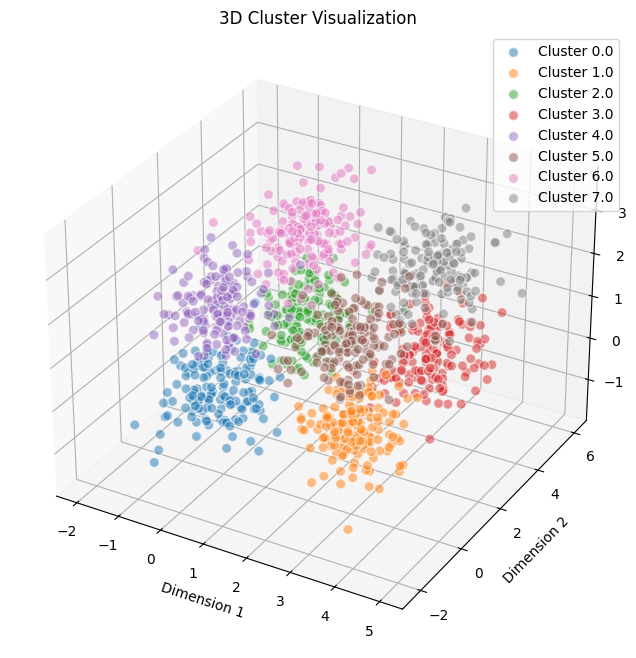

In [6]:
plot_clusters_3d(data_cube, labels_cube)

In [7]:
net = KohonenNet(m=10, n=10, input_dim=3, sigma=1.0, sigma_decay=0.1, learning_rate=0.10, lambda_decay=100)

In [8]:
net.train(data_cube, labels_cube, 200)

In [11]:
accuracy = net.evaluate_accuracy(data_cube, labels_cube)
print(f"Accuracy of cluster assignment: {accuracy:.2f}%")

Accuracy of cluster assignment: 94.50%


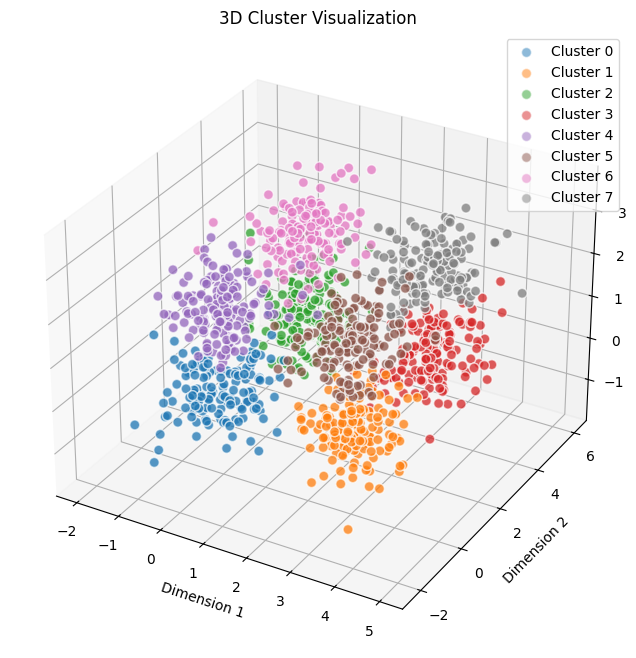

In [12]:
data_for_predict = np.array([item[0] for item in net.predictions])
predicted_labels = np.array([item[1] for item in net.predictions])

plot_clusters_3d(data_for_predict, predicted_labels)

BMU (7, 5) is mostly representing cluster 0.0 (100.00% of samples)
BMU (7, 4) is mostly representing cluster 0.0 (100.00% of samples)
BMU (6, 3) is mostly representing cluster 0.0 (100.00% of samples)
BMU (5, 4) is mostly representing cluster 0.0 (100.00% of samples)
BMU (6, 4) is mostly representing cluster 0.0 (100.00% of samples)
BMU (7, 6) is mostly representing cluster 0.0 (62.50% of samples)
BMU (8, 4) is mostly representing cluster 0.0 (100.00% of samples)
BMU (9, 3) is mostly representing cluster 4.0 (85.71% of samples)
BMU (7, 3) is mostly representing cluster 0.0 (93.33% of samples)
BMU (9, 4) is mostly representing cluster 0.0 (100.00% of samples)
BMU (7, 2) is mostly representing cluster 4.0 (58.33% of samples)
BMU (8, 3) is mostly representing cluster 0.0 (80.00% of samples)
BMU (6, 5) is mostly representing cluster 0.0 (100.00% of samples)
BMU (8, 5) is mostly representing cluster 0.0 (100.00% of samples)
BMU (6, 2) is mostly representing cluster 4.0 (57.14% of samples)
B

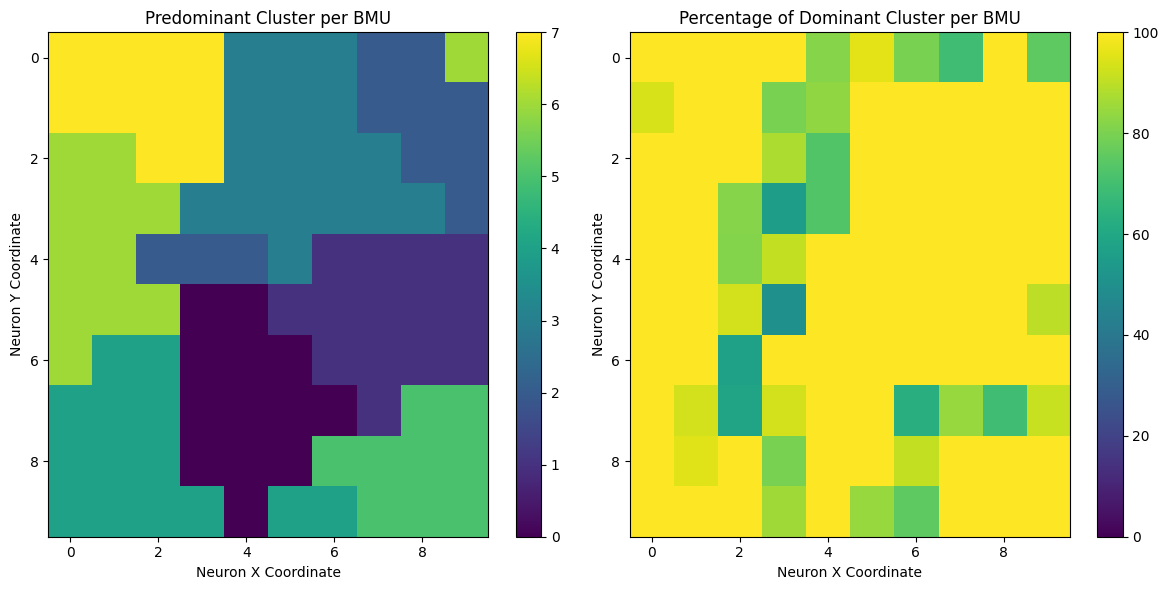

In [13]:
net.map_clusters(data_cube, labels_cube)

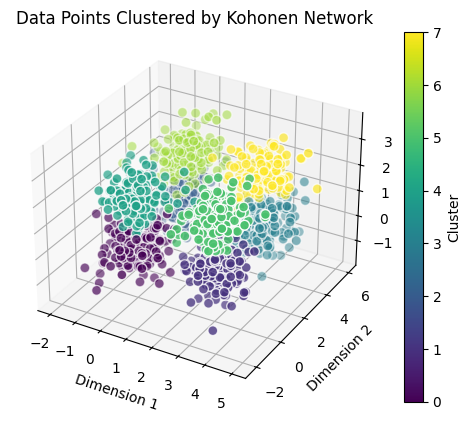

In [14]:
net.visualize_clusters(data_cube)